<a href="https://colab.research.google.com/github/martinpius/Computer-Vission/blob/main/YOLO_from_scratch_with_tensorflow_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are on CoLab with tensorflow version: {tf.__version__}")
except Exception as e:
  print(f"{type(e)}: {e}\n...please load your drive...")
def time_fmt(t:float = 231.28393)->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"{h}: {m:>03}: {s:>05.2f}"
print(f"....testing....testing....testing\ntime elapse in seconds: {time_fmt()}")

Mounted at /content/drive
You are on CoLab with tensorflow version: 2.4.1
....testing....testing....testing
time elapse in seconds: 0: 003: 51.00


In [ ]:
#we build a computer vission model (YOLO) from scratch:
#Basically this is a ussual CNN with a Resnet archtecture with multipe layers stacked together
#The output layer is both regression and classification:

In [ ]:
#Importing the required packs
import struct
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.style.use('fivethirtyeight')
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from tensorflow.keras.models import Model

In [ ]:
#We define the general achitecture for the convolution block (This is a ussual residual block for resnet)
def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) #padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', #  padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x

In [ ]:
#This class build the yolo_v3 achitecture using the convolution block above:
def custom_yolov3():
  input_image = Input(shape=(None, None, 3))
  x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
  
  x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
  
  x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
  
  x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
 
  for i in range(7):
   x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
   
  skip_36 = x
  
  x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
  
  for i in range(7):
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
  skip_61 = x
  
  x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
  for i in range(3):
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    
  x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
  
  yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
  
  x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
  x = UpSampling2D(2)(x)
  x = concatenate([x, skip_61])
  
  x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
  
  yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
  x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
  
  x = UpSampling2D(2)(x)
  x = concatenate([x, skip_36])
  yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
  model = Model(input_image, [yolo_82, yolo_94, yolo_106])
  return model

In [ ]:
#We now define the class to load the weights
class WeightLoader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')

	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]

	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution at layer number " + str(i))

	def reset(self):
		self.offset = 0

In [ ]:
import os
os.getcwd()
os.chdir('/content/drive/MyDrive')

In [ ]:
#define the model
model = custom_yolov3()

#Instantiating the class and load the pre-trained weights for our model
weight_loader = WeightLoader('yolov3.weights')

weight_loader.load_weights(model) 

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution at layer number 4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution at layer number 8
loading weights of convolution #9
loading weights of convolution #10
no convolution at layer number 11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution at layer number 15
loading weights of convolution #16
loading weights of convolution #17
no convolution at layer number 18
loading weights of convolution #19
loading weights of convolution #20
no convolution at layer number 21
loading weights of convolution #22
loading weights of convolution #23
no convolution at layer number 24
loading weights of convolution #25
loading weights of convolution #26
no convolution at layer number 27
loading weights of convolution #28
loa

In [ ]:
model.save('model.h5')

In [ ]:
#Loading the trained model
my_model = load_model('model.h5')

In [ ]:
my_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
____________________________________________________________________________________________

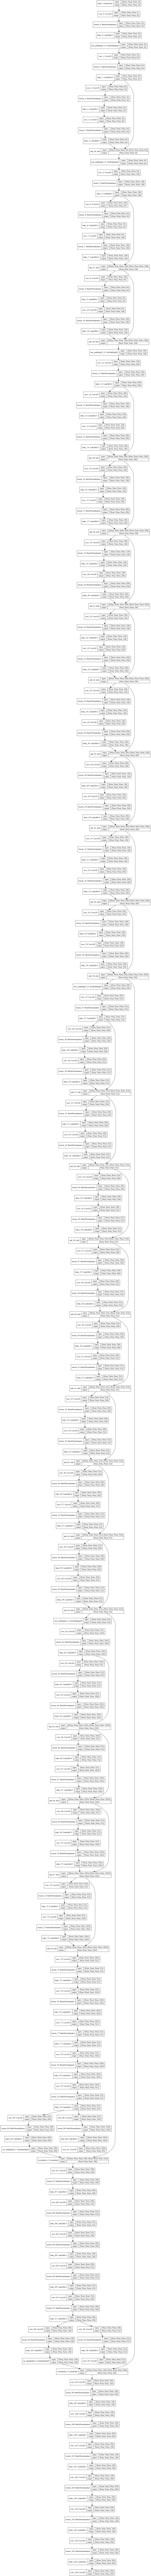

In [ ]:
#Vissualize the model (Its a pretty giant graph though)
tf.keras.utils.plot_model(model = my_model, to_file = 'yolo_customized.png', show_shapes = True)

In [ ]:
img_w, img_h = 416, 416

In [ ]:
#Now we define a class to compute the bounded boxes for each specific image on an image

In [ ]:
class BoundFrame:
  def __init__(self, xmin, ymin, xmax,ymax,objness = None, classes = None):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
    self.classes = classes
    self.objness = objness 
    self.score = -1
    self.label = -1
  
  def get_label(self):
    if self.label == -1:
      self.label = np.argmax(self.classes)
    return self.label
  
  def ge_score(self):
    if self.score == -1:
      self.score = self.classes(self.get_label())
    return self.score

In [ ]:
#define the sigmoid activation function
def sigmoid_act(input):
  return 1./(1. + np.exp(-input))

In [ ]:
#We need to decode the output (images) into numpy arrays. Below is the function
#to do this job

In [ ]:
def decode_img_out(img_out, anchors, object_thresh, img_h, img_w):
  grids_h, grids_w = img_out.shape[:2] #Is given by the height and width of the output image
  n_box = 3 #total number of anchor boxes
  img_out = img_out.reshape(grids_h, grids_w, n_box, -1)
  nb_classes = img_out.shape[-1] - 5
  boxes = [] # boxes place holder
  img_out[..., :2] = sigmoid_act(img_out[..., :2])
  img_out[..., 4:] = sigmoid_act(img_out[..., 4:])
  img_out[..., 5:] = img_out[...,4][...,np.newaxis] *img_out[..., 5:]
  img_out[..., 5:] *= img_out[..., 5:] > object_thresh
   #computing the bounded boxes
  for i in range(grids_h * grids_w):
    row = i / grids_w
    col = i % grids_w
    for b in range(n_box):
      objectness = img_out[int(row)][int(col)][b][4]
      if (objectness.all()) <= object_thresh: continue
      x, y, w, h = img_out[int(row)][int(col)][b][:4] #the first 4 entries
      x = (col + x) / grids_w
      y = (row + x) / grids_h
      w = anchors[2 * b + 0] * np.exp(w) / img_w
      h = anchors[2 * b + 1] * np.exp(h) / img_h
      classes = img_out[int(row)][int(col)][b][5:] #classes of probs
      box = BoundFrame(x - w/2, y - h/2, x + w/2, y + h/2,objectness, classes)
      boxes.append(box)
  return boxes



In [ ]:
#We adjust the boxes dimensions using the follwing procedure
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [ ]:
#The loss function for yolo net involves computation of intersection over union
#The following function do the job: (taken from yolov3 paper)

In [ ]:
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

#intersection over union        
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
    
    
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin  
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    #Union(A,B) = A + B - Inter(A,B)
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

In [ ]:
def do_nms(boxes, nms_thresh):    #boxes from correct_yolo_boxes and  decode_netout
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

In [ ]:
#Now we can load and processes the new images for prediction

In [ ]:
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename) #load_img() Keras function to load the image .
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape) # target_size argument to resize the image after loading
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0  #rescale the pixel values from 0-255 to 0-1 32-bit floating point values.
	# add a dimension so that we have one sample
	image = np.expand_dims(image, 0)
	return image, width, height

In [ ]:
os.chdir("/content/drive/MyDrive/yolo-images")
photo_filename = 'Arusha-park.jpg'
input_w, input_h = 416, 416
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
#print(image, image_w, image_h )
print(image.shape)
# make prediction

(1, 416, 416, 3)


In [ ]:
pred = my_model.predict(image)

In [ ]:
print([i.shape for i in pred]) # shapes of the 3 anchors boxes

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [ ]:
#Filter results above the threshhold

In [ ]:
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)

	return v_boxes, v_labels, v_scores

In [ ]:
#Plot the results

In [ ]:
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = plt.imread(filename)
	# plot the image
	plt.imshow(data)
	# get the context for drawing boxes
	ax = plt.gca()
	# plot each box
	for i in range(len(v_boxes)):
        #by retrieving the coordinates from each bounding box and creating a Rectangle object.
        
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white') 
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		plt.text(x1, y1, label, color='white')
	# show the plot
	plt.show()
draw_boxes

<function __main__.draw_boxes>

In [ ]:
#set the anchoirs
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

person 64.57042098045349
person 79.54193353652954
person 79.40953373908997
person 92.53917336463928
cow 68.89396905899048
cow 65.37034511566162
cow 72.4733054637909
horse 99.83394742012024
horse 99.58254098892212
horse 99.80379343032837


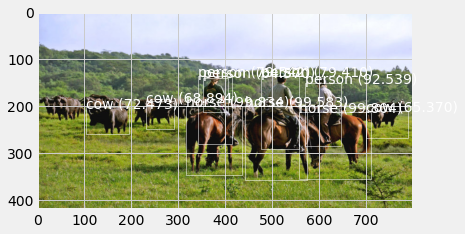

In [ ]:
class_threshold = 0.6
boxes = list()
for i in range(len(pred)):
	# decode the output of the network
	boxes += decode_img_out(pred[i][0], anchors[i], class_threshold, input_h, input_w)
    
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

# suppress non-maximal boxes
do_nms(boxes, 0.5)  #Discard all boxes with pc less or equal to 0.5

# define the labels  80 labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)


#We can also plot our original photograph and draw the bounding box around each detected object.
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)